In [1]:
import polars as pl
import vowpal_wabbit_next as vw
import numpy as np
from sklearn.datasets import make_blobs

from cluster_manager import ClusterManager

In [2]:
import random

# Generate a random float between 10.5 and 75.5
boundl = 0
boundr = 2
random_float = random.uniform(boundl, boundr)
initial_data = [{"d1": random.uniform(boundl, boundr), "d2": random.uniform(boundl, boundr)} for _ in range(4)]

df = pl.DataFrame(initial_data).with_row_index()

df

index,d1,d2
u32,f64,f64
0,0.132943,1.847073
1,0.479741,1.747269
2,0.282203,1.209701
3,0.176033,1.33966


In [4]:
# # (Assuming vw_clustering_utils.py and cluster_manager.py are loaded)
# # from cluster_manager import ClusterManager
# # from vw_clustering_utils import predict_cluster, learn_and_update, apply_human_correction

# # ==========================================
# # 1. GENERATE REALISTIC SYNTHETIC DATA
# # ==========================================
# # We create 150 items that secretly belong to 3 distinct groups
# np.random.seed(42)
# X, ground_truth = make_blobs(n_samples=150, centers=3, cluster_std=1.6, random_state=42)

# df = pl.DataFrame({
#     "index": np.arange(150),
#     "d1": X[:, 0],
#     "d2": X[:, 1],
#     "truth": ground_truth
# })
# df

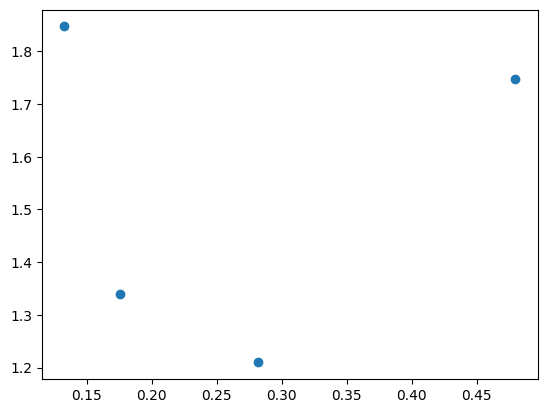

In [3]:
import matplotlib.pyplot as plt

plt.scatter('d1', 'd2', data=df)
plt.show()

## Waffling

In [4]:
cm = ClusterManager()

In [17]:
item = initial_df.row(0, named=True)
cm.get_vw_actions(item["index"], np.array([item["d1"], item["d2"]]))

Exception: Item embedding should not be provided if already existing

In [20]:
cm.get_vw_actions(item["index"])

[{'id': 'cluster_0', 'features': 'f0:1.127706 f1:0.838974'},
 {'id': 'cluster_2', 'features': 'f0:0.442285 f1:1.345998'}]

In [6]:
cm.clusters

{'cluster_0': Cluster(id='cluster_0', medoid=array([0.44228468, 1.3459976 ]), members=[0], size=1)}

In [7]:
cm.item_to_embedding

{0: array([0.44228468, 1.3459976 ])}

In [8]:
cm.item_to_cluster

{0: Cluster(id='cluster_0', medoid=array([0.44228468, 1.3459976 ]), members=[0], size=1)}

In [9]:
cm.balance_clusters()

In [10]:
cm.clusters

{'cluster_0': Cluster(id='cluster_0', medoid=array([0.44228468, 1.3459976 ]), members=[0], size=1)}

In [11]:
item = initial_df.row(1, named=True)
cm.get_vw_actions(item["index"], np.array([item["d1"], item["d2"]]))

[{'id': 'cluster_0', 'features': 'f0:0.442285 f1:1.345998'},
 {'id': 'cluster_1', 'features': 'f0:1.813128 f1:0.331950'}]

In [12]:
item = initial_df.row(1, named=True)
cm.assign_item(item["index"], "cluster_0")

In [13]:
cm.item_to_cluster

{0: Cluster(id='cluster_0', medoid=array([0.44228468, 1.3459976 ]), members=[0, 1], size=2),
 1: Cluster(id='cluster_0', medoid=array([0.44228468, 1.3459976 ]), members=[0, 1], size=2)}

In [21]:
cm.clusters

{'cluster_0': Cluster(id='cluster_0', medoid=array([1.12770629, 0.83897391]), members=[1], size=1),
 'cluster_2': Cluster(id='cluster_2', medoid=array([0.44228468, 1.3459976 ]), members=[0], size=1)}

In [15]:
cm.balance_clusters()

In [16]:
cm.clusters

{'cluster_0': Cluster(id='cluster_0', medoid=array([1.12770629, 0.83897391]), members=[0, 1], size=2)}

## Actual Sim

In [4]:
from utils import predict_cluster, learn_and_update, apply_human_correction, calculate_cost

# Initialize VW and your Cluster Manager
workspace = vw.Workspace(["--cb_explore_adf", "--epsilon", "0.2"])
parser = vw.TextFormatParser(workspace)
cm = ClusterManager()

# 1. The Standard Exploration/Exploitation Loop
for row in df.iter_rows(named=True):
    item_idx = row["index"]
    item_features = np.array([row["d1"], row["d2"]])
    
    # Predict
    chosen_action, prob, actions = predict_cluster(workspace, parser, cm, item_idx, item_features)
    
    # Calculate Cost (e.g., Euclidean distance between item and cluster medoid)
    cost = calculate_cost(cm, item_features, chosen_action["id"])
    
    # Learn and officially assign
    learn_and_update(workspace, parser, cm, item_idx, item_features, actions, 
                     chosen_action["id"], prob, cost)

print("Clusters after automatic assignment:")
print(cm.clusters)

Clusters after automatic assignment:
{'cluster_0': Cluster(id='cluster_0', medoid=array([0.20757289, 1.52838653]), members=[0, 2], size=2), 'cluster_1': Cluster(id='cluster_1', medoid=array([0.47974058, 1.74726893]), members=[1], size=1), 'cluster_3': Cluster(id='cluster_3', medoid=array([0.17603346, 1.33965996]), members=[3], size=1)}


In [5]:
len(cm.clusters)

3

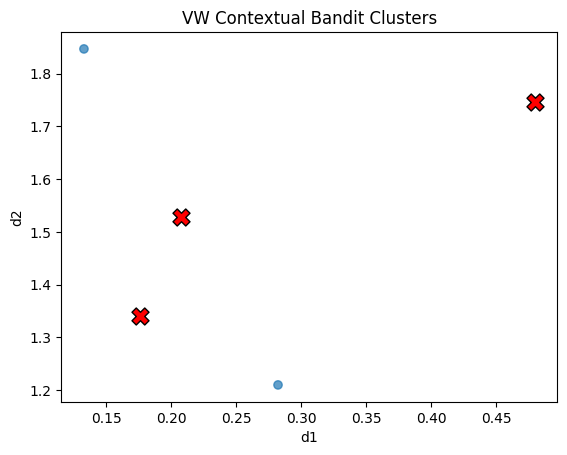

In [6]:
import matplotlib.pyplot as plt

# 1. Create a mapping from your item indices to a numeric color code
item_to_color = {}
for color_code, (cluster_id, cluster) in enumerate(cm.clusters.items()):
    for item_idx in cluster.members:
        item_to_color[item_idx] = color_code

# 2. Build a list of colors in the exact order of your DataFrame rows
# We use .to_list() to safely extract the Polars column, defaulting to -1 if unclustered
color_list = [item_to_color.get(idx, -1) for idx in df["index"].to_list()]

# 3. Plot the points, passing the ordered list to the 'c' parameter
plt.scatter('d1', 'd2', data=df, c=color_list, cmap='tab10', alpha=0.7)

# 4. (Optional but highly recommended) Plot the medoids!
# This plots a large red 'X' at the center of each cluster
for cluster in cm.clusters.values():
    plt.scatter(cluster.medoid[0], cluster.medoid[1], 
                color='red', marker='X', s=150, edgecolor='black')

plt.title("VW Contextual Bandit Clusters")
plt.xlabel("d1")
plt.ylabel("d2")
plt.show()

In [7]:
# 2. Re-clustering via Human Feedback
# Let's say a human decides Item 0 actually belongs in cluster_1
human_correction_item_idx = 3
correct_cluster = "cluster_0"

print(f"\nHuman assigns item {human_correction_item_idx} to {correct_cluster}...")
apply_human_correction(workspace, parser, cm, human_correction_item_idx, correct_cluster)

print("\nFinal Clusters post-correction:")
print(cm.clusters)


Human assigns item 3 to cluster_0...
human doing stuff

Final Clusters post-correction:
{'cluster_0': Cluster(id='cluster_0', medoid=array([0.19705975, 1.46547767]), members=[0, 2, 3], size=3), 'cluster_1': Cluster(id='cluster_1', medoid=array([0.47974058, 1.74726893]), members=[1], size=1)}


In [8]:
len(cm.clusters)

2

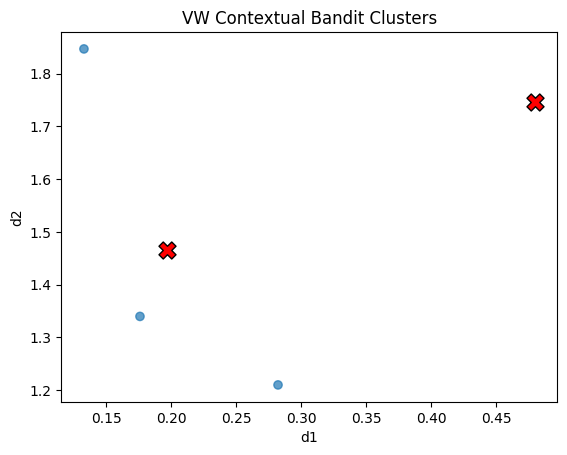

In [9]:
# 1. Create a mapping from your item indices to a numeric color code
item_to_color = {}
for color_code, (cluster_id, cluster) in enumerate(cm.clusters.items()):
    for item_idx in cluster.members:
        item_to_color[item_idx] = color_code

# 2. Build a list of colors in the exact order of your DataFrame rows
# We use .to_list() to safely extract the Polars column, defaulting to -1 if unclustered
color_list = [item_to_color.get(idx, -1) for idx in df["index"].to_list()]

# 3. Plot the points, passing the ordered list to the 'c' parameter
plt.scatter('d1', 'd2', data=df, c=color_list, cmap='tab10', alpha=0.7)

# 4. (Optional but highly recommended) Plot the medoids!
# This plots a large red 'X' at the center of each cluster
for cluster in cm.clusters.values():
    plt.scatter(cluster.medoid[0], cluster.medoid[1], 
                color='red', marker='X', s=150, edgecolor='black')

plt.title("VW Contextual Bandit Clusters")
plt.xlabel("d1")
plt.ylabel("d2")
plt.show()

In [10]:
# 2. Re-clustering via Human Feedback
# Let's say a human decides Item 0 actually belongs in cluster_1
human_correction_item_idx = 0
correct_cluster = "new_cluster"

print(f"\nHuman assigns item {human_correction_item_idx} to {correct_cluster}...")
apply_human_correction(workspace, parser, cm, human_correction_item_idx, correct_cluster)

print("\nFinal Clusters post-correction:")
print(cm.clusters)


Human assigns item 0 to new_cluster...
Warning. Item embedding should not be provided if already existing
human doing stuff

Final Clusters post-correction:
{'cluster_0': Cluster(id='cluster_0', medoid=array([0.22911828, 1.27468025]), members=[2, 3], size=2), 'cluster_1': Cluster(id='cluster_1', medoid=array([0.47974058, 1.74726893]), members=[1], size=1), 'cluster_4': Cluster(id='cluster_4', medoid=array([0.13294268, 1.84707251]), members=[0], size=1)}


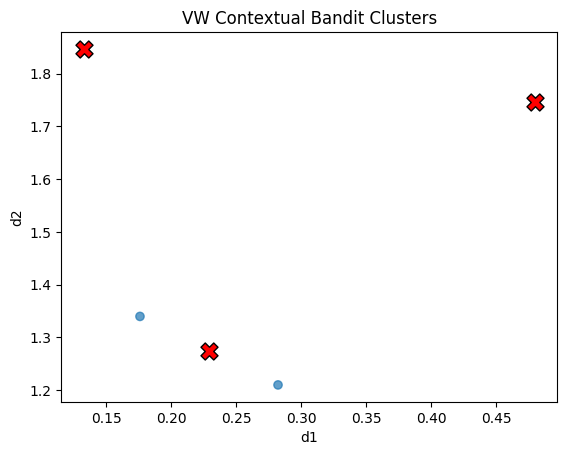

In [11]:
# 1. Create a mapping from your item indices to a numeric color code
item_to_color = {}
for color_code, (cluster_id, cluster) in enumerate(cm.clusters.items()):
    for item_idx in cluster.members:
        item_to_color[item_idx] = color_code

# 2. Build a list of colors in the exact order of your DataFrame rows
# We use .to_list() to safely extract the Polars column, defaulting to -1 if unclustered
color_list = [item_to_color.get(idx, -1) for idx in df["index"].to_list()]

# 3. Plot the points, passing the ordered list to the 'c' parameter
plt.scatter('d1', 'd2', data=df, c=color_list, cmap='tab10', alpha=0.7)

# 4. (Optional but highly recommended) Plot the medoids!
# This plots a large red 'X' at the center of each cluster
for cluster in cm.clusters.values():
    plt.scatter(cluster.medoid[0], cluster.medoid[1], 
                color='red', marker='X', s=150, edgecolor='black')

plt.title("VW Contextual Bandit Clusters")
plt.xlabel("d1")
plt.ylabel("d2")
plt.show()